In [1]:
import sys

print(sys.version)  # 3.6.8

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [2]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    multiply,
    concatenate,
)
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

In [4]:
print("Tensorflow version: ", tf.VERSION)  # 1.13.1
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.15.2
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  True


# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [5]:
filename = "input_noise"

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

# predict_only = False
predict_test_only = False

pd.set_option("display.float_format", lambda x: "{:.6f}".format(x))

In [6]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)

        model.add(Dropout(0.2, noise_shape=noiseShape, input_shape=inputShape))  # black
        model.add(Lambda(lambda x: 1 - x))  # 0 to 1, 1 to 0
        model.add(Dropout(0.1, noise_shape=noiseShape))  # white
        model.add(Lambda(lambda x: 1 - x))
        model.add(Activation("relu"))

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, name="learned_representation"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(name="normalized_representation"))
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [7]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [8]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return parsed_example["floorplan"], parsed_example["norm_year"]


def create_dataset(filepath):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)

    # This dataset will go on forever
    dataset = dataset.repeat()

    # Set the number of datapoints you want to load and shuffle
    dataset = dataset.shuffle(BUFFER_SIZE)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset


train_dataset = create_dataset(path_train_tfrecord)
test_dataset = create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [9]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2],
)

for images, labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())

model.summary()

Logits:  [[0.03074576]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        1760      
_________________________________________________________________
activation_1 (Activation)    (No

In [10]:
model.compile(optimizer="RMSprop", loss="mean_squared_error")

In [11]:
with h5py.File(path_model, "r") as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file["weight" + str(i)][:])

model.set_weights(weight)
# weight

In [12]:
def _parse_predict_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return (
        parsed_example["floorplan"],
        parsed_example["plan_id"],
        parsed_example["norm_year"],
    )


def create_predict_dataset(filepaths):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [13]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [14]:
predict_dataset = create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(predict_dataset, steps=60000 // BATCH_SIZE)

predictions = [x[0] for x in predictions]
# predictions

In [15]:
predict_dataset = create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [16]:
predict_dataset = create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [17]:
df = pd.DataFrame(
    zip(ids, true_year, predictions), columns=["ID", "true_year", "prediction"]
)
df = df.set_index("ID")
df[:10]

,true_year,prediction
ID,,
110064_103A,0.880000,0.854127
109174_143D,0.960000,0.925552
12781_102,0.420000,0.457280
22441_100A,0.700000,0.617508
109174_202,0.960000,0.915293
109360_101B,0.960000,0.930704
3027_80C,0.640000,0.650589
27211_109B,0.840000,0.813593
10630_108C,0.680000,0.721259


In [18]:
path_csv = "/data/fp_refined.csv"
df_csv = pd.read_csv(path_csv, index_col="id_after")
df_csv.columns

Index(['Path', 'index', 'APT_ID', 'Date', 'year', 'norm_year', 'yyyymm',
       'N_Housings', 'Max_Floors', 'Min_Floors', 'name', 'emd', 'emd_name',
       'sgg', 'sgg_name', 'sido', 'sido_name', 'sido_cluster',
       'sido_cluster_code', 'sido_sgg_name', 'FP_ID', 'Area', 'norm_log_area',
       'area_85', 'Entrance', 'Rooms', 'Baths', 'N_Units'],
      dtype='object')

In [19]:
if not "N_Units" in df.columns:
    df = df.join(
        df_csv[
            [
                #                 "id_after",
                "year",
                "N_Housings",
                "N_Units",
                "Max_Floors",
                "Min_Floors",
                "sgg",
                "sido_sgg_name",
                "sido",
                "sido_name",
                "sido_cluster_code",
                "sido_cluster",
                "Area",
                "norm_log_area",
                "area_85",
                "Entrance",
                "Rooms",
                "Baths",
            ]
        ],
    )
# .set_index("id_after"),on="ID"
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50540 entries, 110064_103A to 26135_110
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   true_year          50540 non-null  float64
 1   prediction         50540 non-null  float64
 2   year               50540 non-null  int64  
 3   N_Housings         50540 non-null  int64  
 4   N_Units            50540 non-null  int64  
 5   Max_Floors         50540 non-null  int64  
 6   Min_Floors         50540 non-null  int64  
 7   sgg                50540 non-null  int64  
 8   sido_sgg_name      50540 non-null  object 
 9   sido               50540 non-null  int64  
 10  sido_name          50540 non-null  object 
 11  sido_cluster_code  50540 non-null  int64  
 12  sido_cluster       50540 non-null  object 
 13  Area               50540 non-null  float64
 14  norm_log_area      50540 non-null  float64
 15  area_85            50540 non-null  bool   
 16  Entrance     

In [20]:
df[:10]

,true_year,prediction,year,N_Housings,N_Units,Max_Floors,Min_Floors,sgg,sido_sgg_name,sido,sido_name,sido_cluster_code,sido_cluster,Area,norm_log_area,area_85,Entrance,Rooms,Baths
ID,,,,,,,,,,,,,,,,,,,
110064_103A,0.880000,0.854127,2013,446,90,9,7,4511100000,전라북도 전주시 완산구,4500000000,전라북도,7,광주전라,84.730000,-0.009134,True,계단식,3,2
109174_143D,0.960000,0.925552,2017,163,5,19,7,1171000000,서울시 송파구,1100000000,서울시,0,서울,110.270000,0.747274,False,계단식,4,2
12781_102,0.420000,0.457280,1990,208,104,13,13,4213000000,강원도 원주시,4200000000,강원도,3,강원,84.970000,-0.001013,True,계단식,3,2
22441_100A,0.700000,0.617508,2004,43,19,12,9,1171000000,서울시 송파구,1100000000,서울시,0,서울,82.700000,-0.078757,False,계단식,3,2
109174_202,0.960000,0.915293,2017,163,1,19,7,1171000000,서울시 송파구,1100000000,서울시,0,서울,152.440000,1.677027,False,계단식,4,3
109360_101B,0.960000,0.930704,2017,1387,153,28,28,4159000000,경기도 화성시,4100000000,경기도,1,경기,75.940000,-0.323588,False,계단식,3,2
3027_80C,0.640000,0.650589,2001,704,67,25,17,4131000000,경기도 구리시,4100000000,경기도,1,경기,54.550000,-1.273399,False,계단식,2,1
27211_109B,0.840000,0.813593,2011,199,47,15,9,1129000000,서울시 성북구,1100000000,서울시,0,서울,84.810000,-0.006425,True,계단식,3,2
10630_108C,0.680000,0.721259,2003,634,80,20,15,4311200000,충청북도 청주시 서원구,4300000000,충청북도,4,대전세종충청,84.750000,-0.008457,True,계단식,3,2


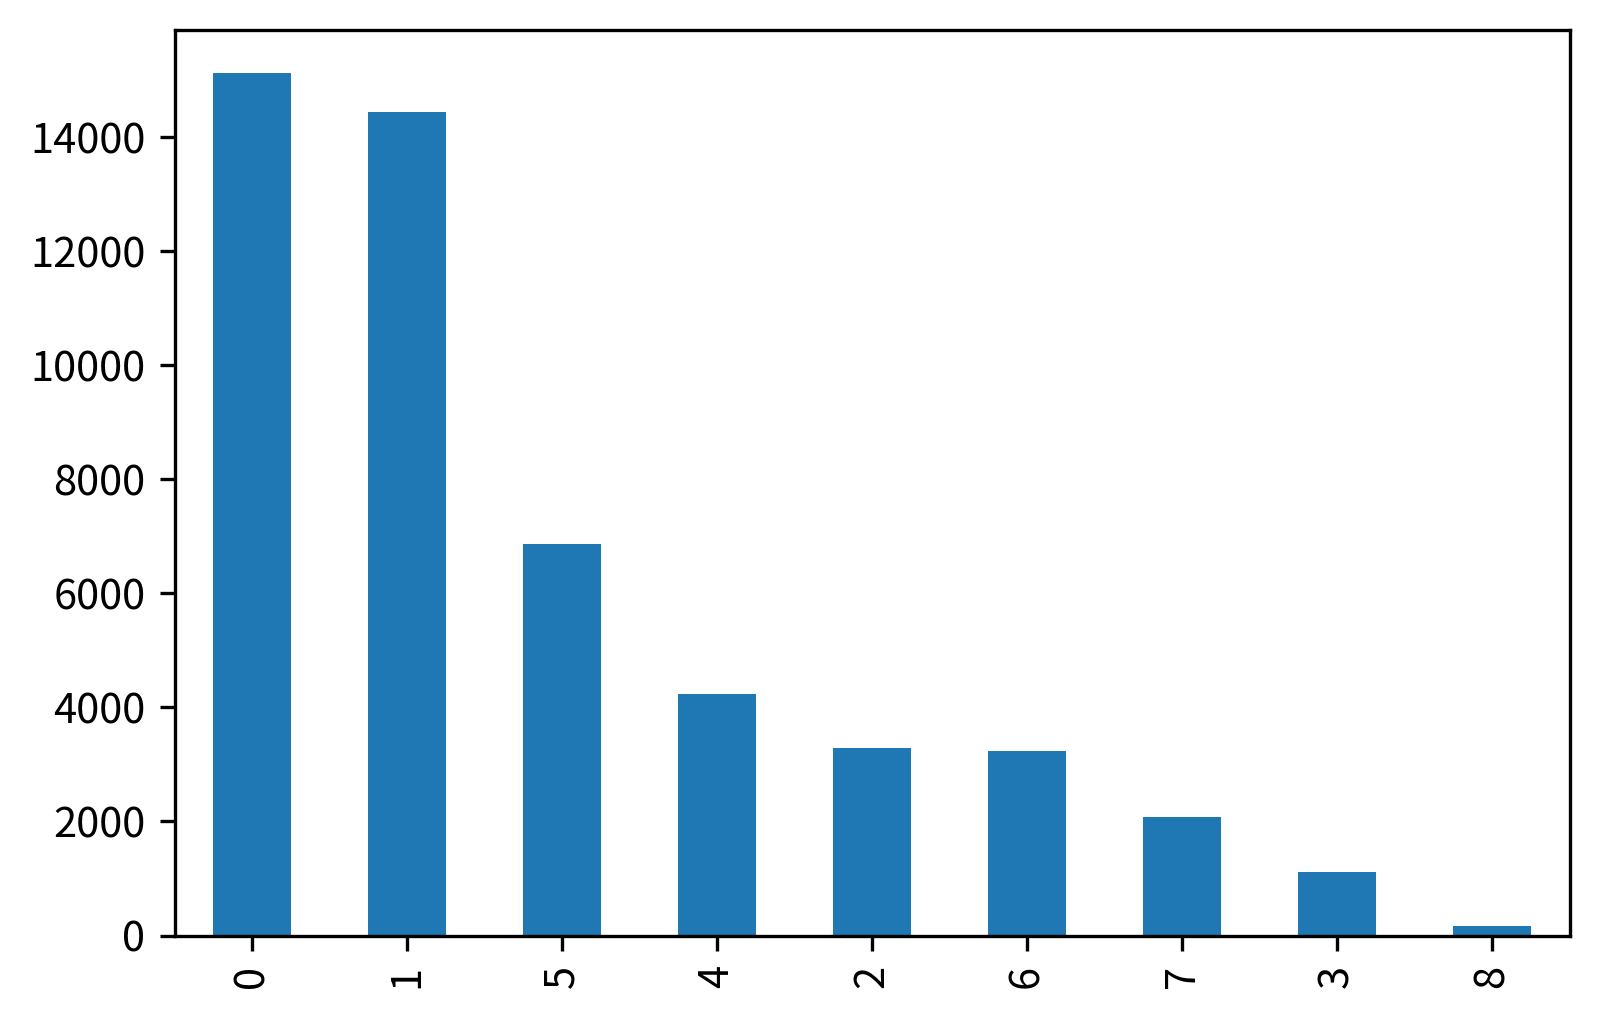

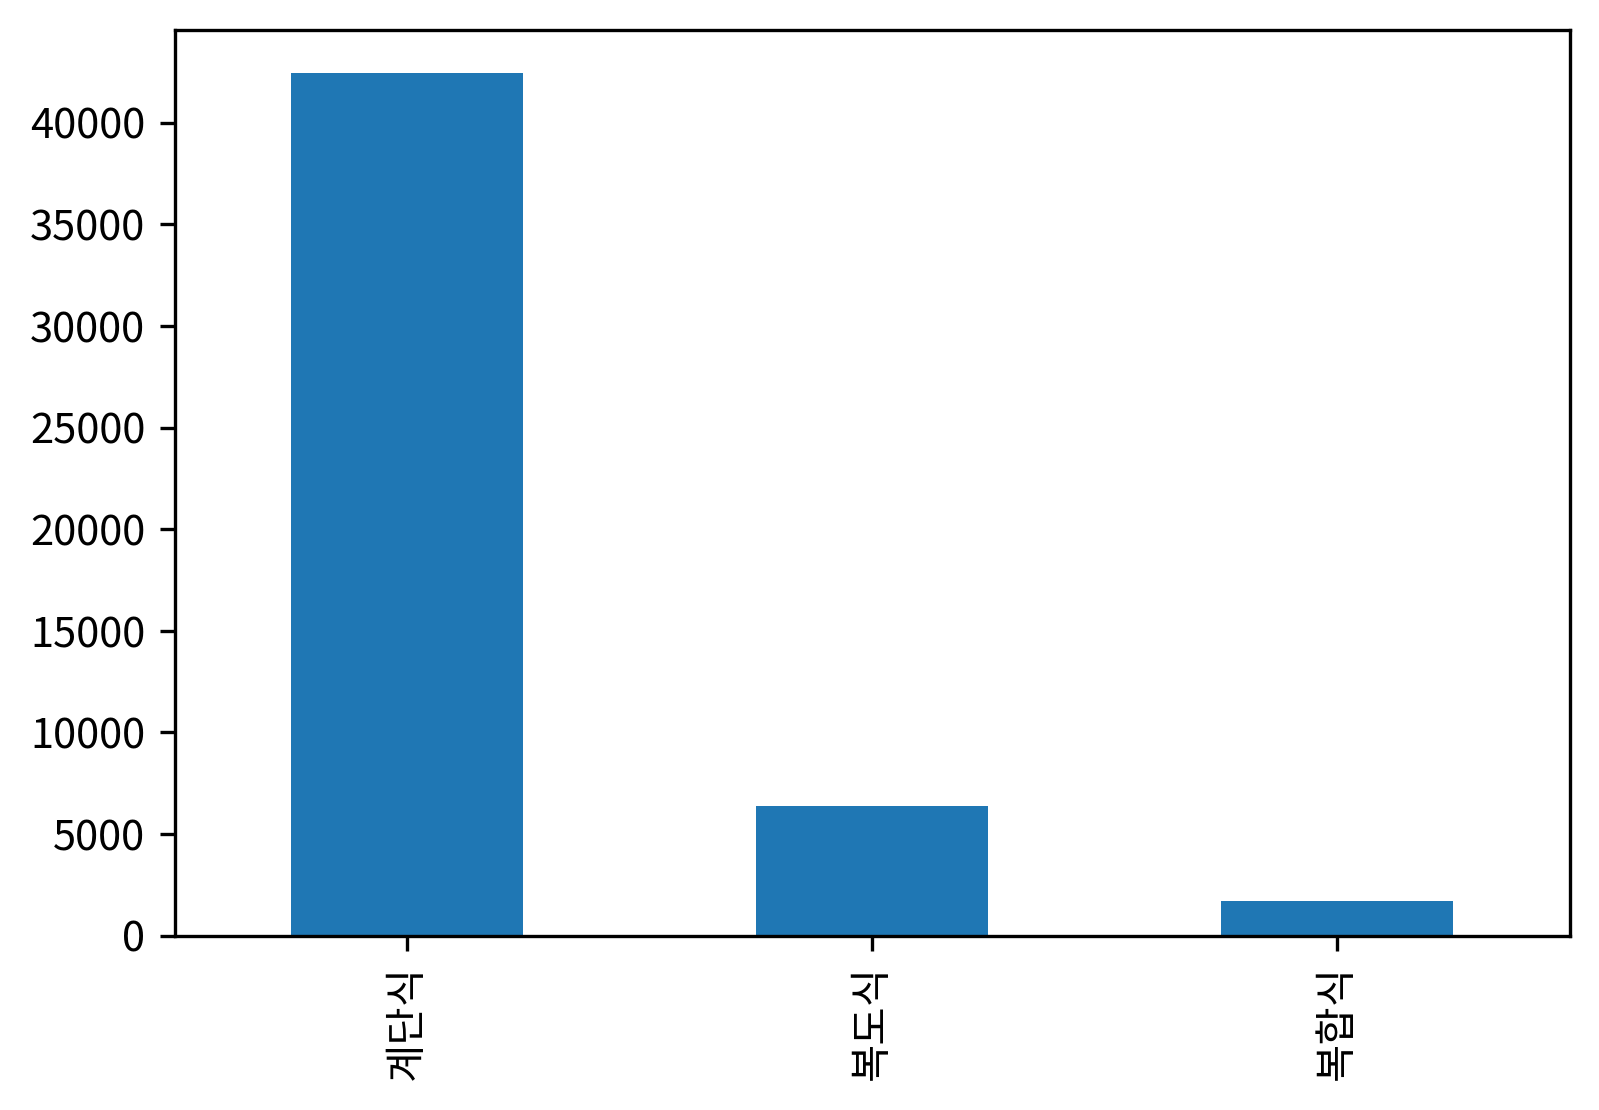

In [33]:
for col in [
    "sido_cluster_code",
    "Entrance",
]:
    with plt.rc_context({'font.family': 'noto sans kr'}):
        fig=plt.figure(dpi=300)
        df[col].value_counts().plot.bar()    

In [26]:
fig.get_label()

''

In [ ]:
for col in [
    "Max_Floors",
    "norm_log_area",
    "Rooms",
]:
    fig=plt.figure()
    df[col].plot.kde()

# residual (deviation)

In [ ]:
y_pred = df["prediction"]
y_true = df["true_year"]

In [ ]:
fig = plt.figure(figsize=(11, 9), dpi=300)
ax = fig.gca()
pd.concat([y_true, y_pred], axis=1).plot.hexbin(
    "true_year", "prediction", bins="log", gridsize=(30, 40), ax=ax
)
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.xaxis.set_tick_params(which="both", labelbottom=True)

In [ ]:
df.true_year.value_counts().sort_index()

In [ ]:
year_counts = df["true_year"].value_counts().rename("year_counts")
if not "year_counts" in df.columns:
    df = df.merge(
        year_counts.to_frame(), how="left", left_on="true_year", right_index=True,
    )
df["year_counts"][:10]

In [ ]:
pred_median = (
    df[df.year_counts > 100]
    .groupby("true_year")["prediction"]
    .median()
    .rename("pred_median")
)
if not "pred_median" in df.columns:
    df = df.merge(
        pred_median.to_frame(), how="left", left_on="true_year", right_index=True,
    )
df["pred_median"][:10]

In [ ]:
# 시기별 예측 연도

fig = plt.figure(figsize=(11, 9), dpi=300)
ax = fig.gca()
df.plot.hexbin("true_year", "prediction", bins="log", gridsize=(30, 40), ax=ax)

ax.plot([0, 1], [0, 1], c="k", ls=":", alpha=0.5)

pred_median.reset_index().plot.scatter("true_year", "pred_median", c="w", ax=ax)

ax.xaxis.set_tick_params(which="both", labelbottom=True)

bounds = np.asarray([1969, 2019])
limits = (bounds - 1969) / 50

# limits = np.asarray([0.26, 0.96])
# bounds = (1969 + limits * 50).astype(int)

ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.set_aspect(1)

ticklabels = np.sort(
    np.append(
        bounds, np.arange(*((np.asarray((bounds + [14, -5])) // 10) * 10 + [0, 1]), 10),
    )
)
ticks = (ticklabels - 1969) / 50

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)

ax.set_xlabel("Completion Year")
ax.set_ylabel("Prediction")
fig.show()

In [ ]:
df["pred_dev"] = df["prediction"] - df["pred_median"]
df_dev = df[df.pred_dev.notna()]

In [ ]:
# 시기별 예측 오차
ycol = "pred_dev"

xlimits = np.asarray([0.26, 0.96])
xbounds = (1969 + xlimits * 50).astype(int)

ybounds = np.asarray([-15, 15])
ylimits = ybounds / 50

fig = plt.figure(figsize=(11, 7), dpi=300)
ax = fig.gca()
df.plot.hexbin("true_year", ycol, bins="log", gridsize=(29, 37), ax=ax)

ax.plot(xlimits, [0, 0], c="k", ls=":", alpha=0.5)

plt.scatter(pred_median.index, np.zeros_like(pred_median), c="w")

ax.xaxis.set_tick_params(which="both", labelbottom=True)

ax.set_xlim(*xlimits)
ax.set_ylim(*ylimits)
ax.set_aspect(1)

xticklabels = np.sort(
    np.append(
        xbounds,
        np.arange(*((np.asarray((xbounds + [14, -5])) // 10) * 10 + [0, 1]), 10),
    )
)
yticklabels = np.sort(
    np.append(
        ybounds, np.arange(*((np.asarray((ybounds + [7, -2])) // 5) * 5 + [0, 1]), 5),
    )
)

xticks = (xticklabels - 1969) / 50
yticks = (yticklabels) / 50

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

ax.set_xlabel("Completion Year")
ax.set_ylabel("Deviation from Median (year)")
fig.show()

## 지역

In [ ]:
from itertools import combinations
from scipy.stats import ttest_ind

tts = []
for i, j in combinations(np.sort(df["sido_cluster_code"].unique()), 2):
    t, p = ttest_ind(
        df_dev[df_dev.sido_cluster_code == i]["pred_dev"],
        df_dev[df_dev.sido_cluster_code == j]["pred_dev"],
    )
    tts.append((i, j, t, p))

tts

In [ ]:
from statsmodels.stats.multitest import multipletests

# holm-sidak : step down method using Sidak adjustments
# alpha = 0.05
reject, pvals_corrected, _, _ = multipletests([pval for _, _, _, pval in tts])

for i in range(9):
    for tt, r, pv in zip(tts, reject, pvals_corrected):
        if tt[0] == i or tt[1] == i:
            print(f"{tt[0]}-{tt[1]}: {r}, t={tt[2]:.1f}, p_corr={pv:.4f}")

    print("---")

In [ ]:
df_dev.groupby("sido_cluster_code")["pred_dev"].mean().sort_values(ascending=False) * 50

t-검정 결과의 유의확률을 Holm-Sidak 법을 적용하여 최소한 하나의 제1종오류가 발생할 가능성(familywise error rate; FWER)이 0.05가 되도록 보정하여 분석하였다.

714 > 652 > 0  
3, 8은 알 수 없음

경기/충청/전라 > 인천/경상 > 서울

강원/제주는 사례 수 부족으로 지역 대부분과의 차이를 파악할 수 없음

모든 지역의 평균 차이의 크기가 1년 미만으로,
평면계획과 준공연도 사이에 존재하는 다양한 영향 요인들을 배제할 수 있을 만큼 큰 차이는 아니다.

통계적으로 유의한 결과에도 불구하고, 현실적으로는 지역 사이에 시차를 두고 평면유형이 적용되지 않는다고 결론내릴 수 있다.